In [34]:
# ! pip install pandas
# ! pip install numpy
# ! pip install matplotlib
# ! pip install pmdarima
# ! pip install arch

In [35]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import numpy as np
import random
import matplotlib.pyplot as plt
import yfinance as yf  # Import yfinance library for fetching historical ticker data
import math
import scipy.stats as scs
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from arch import arch_model
from arch.univariate import HARX
from statsmodels.tools.sm_exceptions import ValueWarning
import warnings
warnings.simplefilter('ignore')


# Task 1

### Task 1.1

In [36]:
# Read the CSV file into a pandas DataFrame
df = pd.read_csv('content/IBM_202001.csv.gz', compression='gzip')

original_length = len(df)
original_length


# F1
# Removing entries with either transaction price, transaction size, ask price, ask size, bid price or bid size ≤ 0
df_out = (df['NBB'] <= 0) | (df['NBBqty'] <= 0) |  (df['NBO'] <= 0) | (df['NBOqty'] <= 0) | (df['PRICE'] <= 0) | (df['SIZE'] <= 0)
df = df[~df_out].reset_index(drop=True)

# calculating no. of entries removed in f1
f1 = original_length - len(df)
f1_cleaned_length = len(df)


# F2
# Removing entries with either transaction price, transaction size, ask price, ask size, bid price or bid size ≤ 0
df_out = (df['NBB'] <= 0) | (df['NBBqty'] <= 0) |  (df['NBO'] <= 0) | (df['NBOqty'] <= 0) | (df['PRICE'] <= 0) | (df['SIZE'] <= 0)
df = df[~df_out].reset_index(drop=True)

# calculating no. of entries removed in f1
f1 = original_length - len(df)
f1_cleaned_length = len(df)


# F2
# Remove entries with negative bid-ask spread
df['SPREAD'] = df['NBO'] - df['NBB']
df = df[~(df['SPREAD'] <= 0)].reset_index(drop=True)

f2 = f1_cleaned_length - len(df)
f2_cleaned_length = len(df)


# F3
df['Stamp'] = pd.to_datetime(df['DATE'], format='%d%b%Y') + df['TIME_M'].apply(lambda x: pd.Timedelta(x,unit='sec'))
# Group by 'DATE', 'TIME', 'EX', and 'BuySell'
df = df.groupby(['Stamp', 'DATE', 'EX', 'BuySell']).agg({
    'PRICE': 'median',
    'NBO': 'median',
    'NBB': 'median',
    'SIZE': 'sum',
    'NBOqty': 'sum',
    'NBBqty': 'sum'
}).reset_index()

f3 = f2_cleaned_length - len(df)
f3_cleaned_length = len(df)


# F4
# Remove entries for which the spread is more that 50 times the median spread on that day
df['SPREAD'] = df['NBO'] - df['NBB']

medspread = df['SPREAD'].median()
df = df[~(df['SPREAD'] > 50*medspread)].reset_index(drop=True)

f4 = f3_cleaned_length - len(df)
f4_cleaned_length = len(df)


# F5
## Delete entries with prices that are above the `ask' plus the bid–ask spread. 
## Similar for entries with prices below the `bid' minus the bid–ask spread
df_out = (df['PRICE'] > df['NBO'] + df['SPREAD']) | (df['PRICE'] < df['NBB'] - df['SPREAD'])
df = df[~df_out]

f5 = f4_cleaned_length - len(df)
f5_cleaned_length = len(df)


# Summary
summary = pd.DataFrame({
    'F1': [f1, f1/original_length*100],
    'F2': [f2, f2/original_length*100],
    'F3': [f3, f3/original_length*100],
    'F4': [f4, f4/original_length*100],
    'F5': [f5, f5/original_length*100],
}, index=['Number', 'Proportion'])

df.set_index('Stamp', drop=True, inplace = True)

summary.round(2)

,F1,F2,F3,F4,F5
Number,0.0,14375.00,222406.00,0.0,7063.00
Proportion,0.0,1.46,22.58,0.0,0.72


### Task 1.2

In [37]:
df

,DATE,EX,BuySell,PRICE,NBO,NBB,SIZE,NBOqty,NBBqty,SPREAD
Stamp,,,,,,,,,,
2020-01-02 09:30:00.226,02JAN2020,P,1.0,135.100,135.10,134.88,2.0,1000.0,200.0,0.22
2020-01-02 09:30:00.381,02JAN2020,K,1.0,135.090,135.10,134.62,1.0,500.0,600.0,0.48
2020-01-02 09:30:00.600,02JAN2020,N,1.0,135.000,135.10,134.62,148164.0,1000.0,1200.0,0.48
2020-01-02 09:30:00.609,02JAN2020,N,1.0,134.990,135.10,134.62,11.0,500.0,600.0,0.48
2020-01-02 09:30:00.642,02JAN2020,D,1.0,134.995,135.00,134.91,40.0,500.0,100.0,0.09
...,...,...,...,...,...,...,...,...,...,...
2020-01-31 15:59:59.987,31JAN2020,Z,-1.0,143.700,143.74,143.70,100.0,8300.0,10400.0,0.04
2020-01-31 15:59:59.989,31JAN2020,Z,-1.0,143.700,143.74,143.70,100.0,8300.0,10400.0,0.04
2020-01-31 15:59:59.994,31JAN2020,N,-1.0,143.700,143.71,143.70,10600.0,20800.0,300.0,0.01


In [38]:
freqs = ['1S', '2S', '3S', '4S', '5S', '10S', '15S', '20S', '30S', '40S', '50S', '1min', '2min', '3min', '4min', '5min', '6min', '7min', '8min', '9min', '10min', '15min', '20min', '30min']

df['Return'] = np.log(df['PRICE']/df['PRICE'].shift(1))

RVdf = pd.DataFrame(index=pd.unique(df['DATE']))
BVdf = pd.DataFrame(index=pd.unique(df['DATE']))
TRVdf = pd.DataFrame(index=pd.unique(df['DATE']))

def RV(ret,freq='5min'):
    # ret: pandas series of intraday log returns with datetime index
    # freq: string - frequency to be used
    
    ret.dropna(inplace=True)
    ret_freq = ret.resample(rule=freq,closed ='right',label ='right').apply('sum')
    return sum(ret_freq**2)


for freq in freqs:
    RVdf[freq] = RV(df['Return'],freq)*10000 
    # BVdf[freq] = BV
    # TRVdf[freq] = TRV

for data_frames in [RVdf, BVdf, TRVdf]:
    print(data_frames.head())

                  1S         2S         3S         4S         5S        10S  \
02JAN2020  80.390014  73.109499  69.339843  66.399442  64.875876  60.080791   
03JAN2020  80.390014  73.109499  69.339843  66.399442  64.875876  60.080791   
06JAN2020  80.390014  73.109499  69.339843  66.399442  64.875876  60.080791   
07JAN2020  80.390014  73.109499  69.339843  66.399442  64.875876  60.080791   
08JAN2020  80.390014  73.109499  69.339843  66.399442  64.875876  60.080791   

                 15S       20S        30S       40S  ...       4min  \
02JAN2020  58.428556  57.60915  58.726957  56.18884  ...  59.239277   
03JAN2020  58.428556  57.60915  58.726957  56.18884  ...  59.239277   
06JAN2020  58.428556  57.60915  58.726957  56.18884  ...  59.239277   
07JAN2020  58.428556  57.60915  58.726957  56.18884  ...  59.239277   
08JAN2020  58.428556  57.60915  58.726957  56.18884  ...  59.239277   

                5min       6min       7min       8min       9min      10min  \
02JAN2020  55.59459

In [39]:
freqs = ['1S', '2S', '3S', '4S', '5S', '10S', '15S', '20S', '30S', '40S', '50S', '1min', '2min', '3min', '4min', '5min', '6min', '7min', '8min', '9min', '10min', '15min', '20min', '30min']

RVdf = pd.DataFrame(index=pd.unique(df['DATE']))
BVdf = pd.DataFrame(index=pd.unique(df['DATE']))
TRVdf = pd.DataFrame(index=pd.unique(df['DATE']))

for freq in freqs:
    resampled_price =  df['PRICE'].resample(freq).ohlc()['close']

    log_returns = np.log(resampled_price).diff().dropna()

    RV = (log_returns**2).resample('D').sum()

    BV = (log_returns.abs().iloc[:-1] * log_returns.abs().shift(-1).iloc[:-1]).resample('D').sum() * (np.pi / 2)

    threshold = log_returns.quantile(0.975)  # Using the 97.5th percentile as the threshold
    TRV = (log_returns**2).where(log_returns.abs() <= threshold).resample('D').sum()

    RVdf[freq] = RV
    BVdf[freq] = BV
    TRVdf[freq] = TRV

for data_frames in [RVdf, BVdf, TRVdf]:
    print(data_frames.head())

                 1S        2S        3S        4S        5S       10S  \
02JAN2020  0.000062  0.000072  0.000075  0.000079  0.000070  0.000069   
03JAN2020  0.000102  0.000135  0.000135  0.000137  0.000128  0.000107   
06JAN2020  0.000067  0.000085  0.000081  0.000082  0.000079  0.000064   
07JAN2020  0.000094  0.000121  0.000086  0.000094  0.000096  0.000079   
08JAN2020  0.000064  0.000086  0.000097  0.000103  0.000105  0.000089   

                15S       20S       30S       40S  ...      4min      5min  \
02JAN2020  0.000064  0.000058  0.000055  0.000053  ...  0.000071  0.000053   
03JAN2020  0.000090  0.000087  0.000079  0.000076  ...  0.000076  0.000060   
06JAN2020  0.000049  0.000046  0.000036  0.000036  ...  0.000026  0.000026   
07JAN2020  0.000063  0.000058  0.000056  0.000059  ...  0.000040  0.000033   
08JAN2020  0.000085  0.000075  0.000077  0.000066  ...  0.000050  0.000051   

               6min      7min      8min      9min     10min     15min  \
02JAN2020  0.000062

### Task 1.3

Text(0, 0.5, 'Averaged RV')

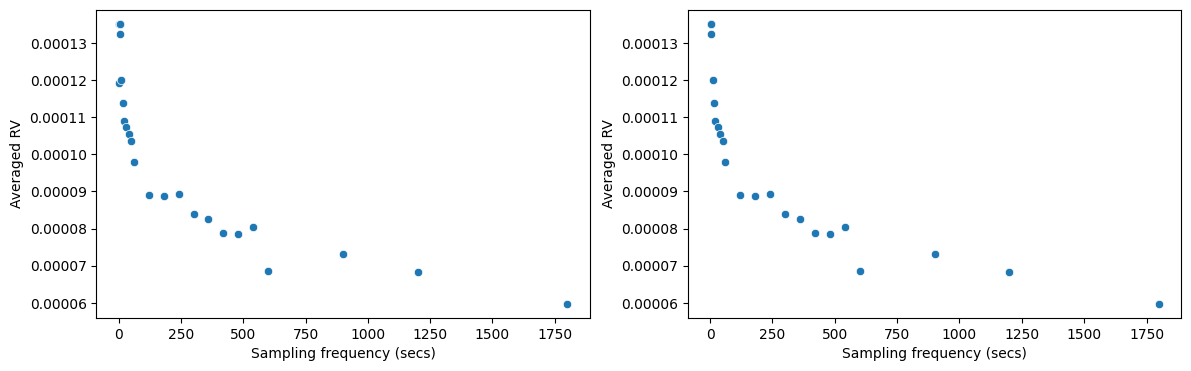

In [40]:
# Compute Average RVs across different days
RVav = RVdf.mean()
# Convert index to integers (sec)
RVav.index
time = [0] + [pd.Timedelta(x).total_seconds() for x in RVav.index[1:]]

fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(14,4))
sns.scatterplot(x=time,y=RVav,ax=axes[0])
axes[0].set_xlabel('Sampling frequency (secs)')
axes[0].set_ylabel('Averaged RV')
sns.scatterplot(x=time[1:],y=RVav[1:],ax=axes[1])
axes[1].set_xlabel('Sampling frequency (secs)')
axes[1].set_ylabel('Averaged RV')


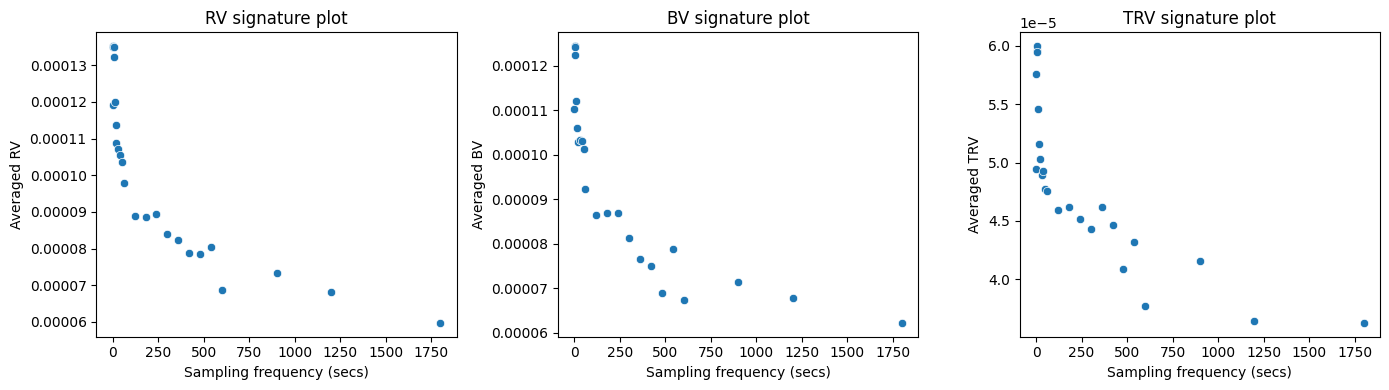

In [41]:
# Compute Average RVs across different days
RVav = RVdf.mean()
# Convert index to integers (sec)
RVav.index
time_RV = [0] + [pd.Timedelta(x).total_seconds() for x in RVav.index[1:]]


# Compute Average RVs across different days
BVav = BVdf.mean()
# Convert index to integers (sec)
BVav.index
time_BV = [0] + [pd.Timedelta(x).total_seconds() for x in BVav.index[1:]]


# Compute Average RVs across different days
TRVav = TRVdf.mean()
# Convert index to integers (sec)
TRVav.index
time_TRV = [0] + [pd.Timedelta(x).total_seconds() for x in TRVav.index[1:]]



fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(14,4))

sns.scatterplot(x=time_RV,y=RVav,ax=axes[0])
axes[0].set_title('RV signature plot')
axes[0].set_xlabel('Sampling frequency (secs)')
axes[0].set_ylabel('Averaged RV')

sns.scatterplot(x=time_BV,y=BVav,ax=axes[1])
axes[1].set_title('BV signature plot')
axes[1].set_xlabel('Sampling frequency (secs)')
axes[1].set_ylabel('Averaged BV')

sns.scatterplot(x=time_TRV,y=TRVav,ax=axes[2])
axes[2].set_title('TRV signature plot')
axes[2].set_xlabel('Sampling frequency (secs)')
axes[2].set_ylabel('Averaged TRV')

plt.tight_layout()

# Task 2

### Task 2.1

In [42]:
student_id = 36629202  # Use your actual student ID here
random.seed(student_id)
djia_tickers = pd.read_csv('DowJones-Feb2022.csv')

djia_tickers = djia_tickers['Ticker'].unique().tolist()  # Get unique ticker symbols
djia_tickers.remove('DOW')  # Remove 'DOW' from the list of ticker symbols

# Randomly select 2 ticker symbols from the DJIA index
my_sample = sorted(random.sample(djia_tickers,2))
my_sample = ['WBA', 'WMT']
startdate = '2010-01-01'
enddate = '2023-12-31'     # Specify end date for historical data

dfs = []
for ticker in my_sample:
    # Download historical ticker prices for the selected ticker symbols
    data = yf.download(ticker, start = startdate, end = enddate)
    data.rename(columns={"Adj Close": "price"}, inplace = True)
    data['return'] = np.log(data['price']/data['price'].shift(1)) # Log return
    data.dropna(inplace = True)
    dfs.append(data)

columns = [(ticker, col) for ticker in my_sample for col in data.columns]
data = pd.concat(dfs, axis=1)

# Assigning MultiIndex to columns
data.columns = pd.MultiIndex.from_tuples(columns)

data_train = data[data.index <= '2020-12-31']

# Choose ARMA parameters to minimize AIC
best_models = {}
for ticker in my_sample:
    model_p = pm.auto_arima(100*data_train[ticker]['return'],start_p=0, start_q=0, max_p=3, max_q=3,test='adf',
                        seasonal=False,trace=False,stepwise=False,with_intercept=True)
    print(f"Best-fitted ARMA model for {ticker}: ARMA{model_p.order} - AIC = {model_p.aic():.4f}")
    best_models[ticker] = model_p

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Best-fitted ARMA model for WBA: ARMA(2, 0, 2) - AIC = 11036.8660
Best-fitted ARMA model for WMT: ARMA(2, 0, 3) - AIC = 8810.5708


### Task 2.2

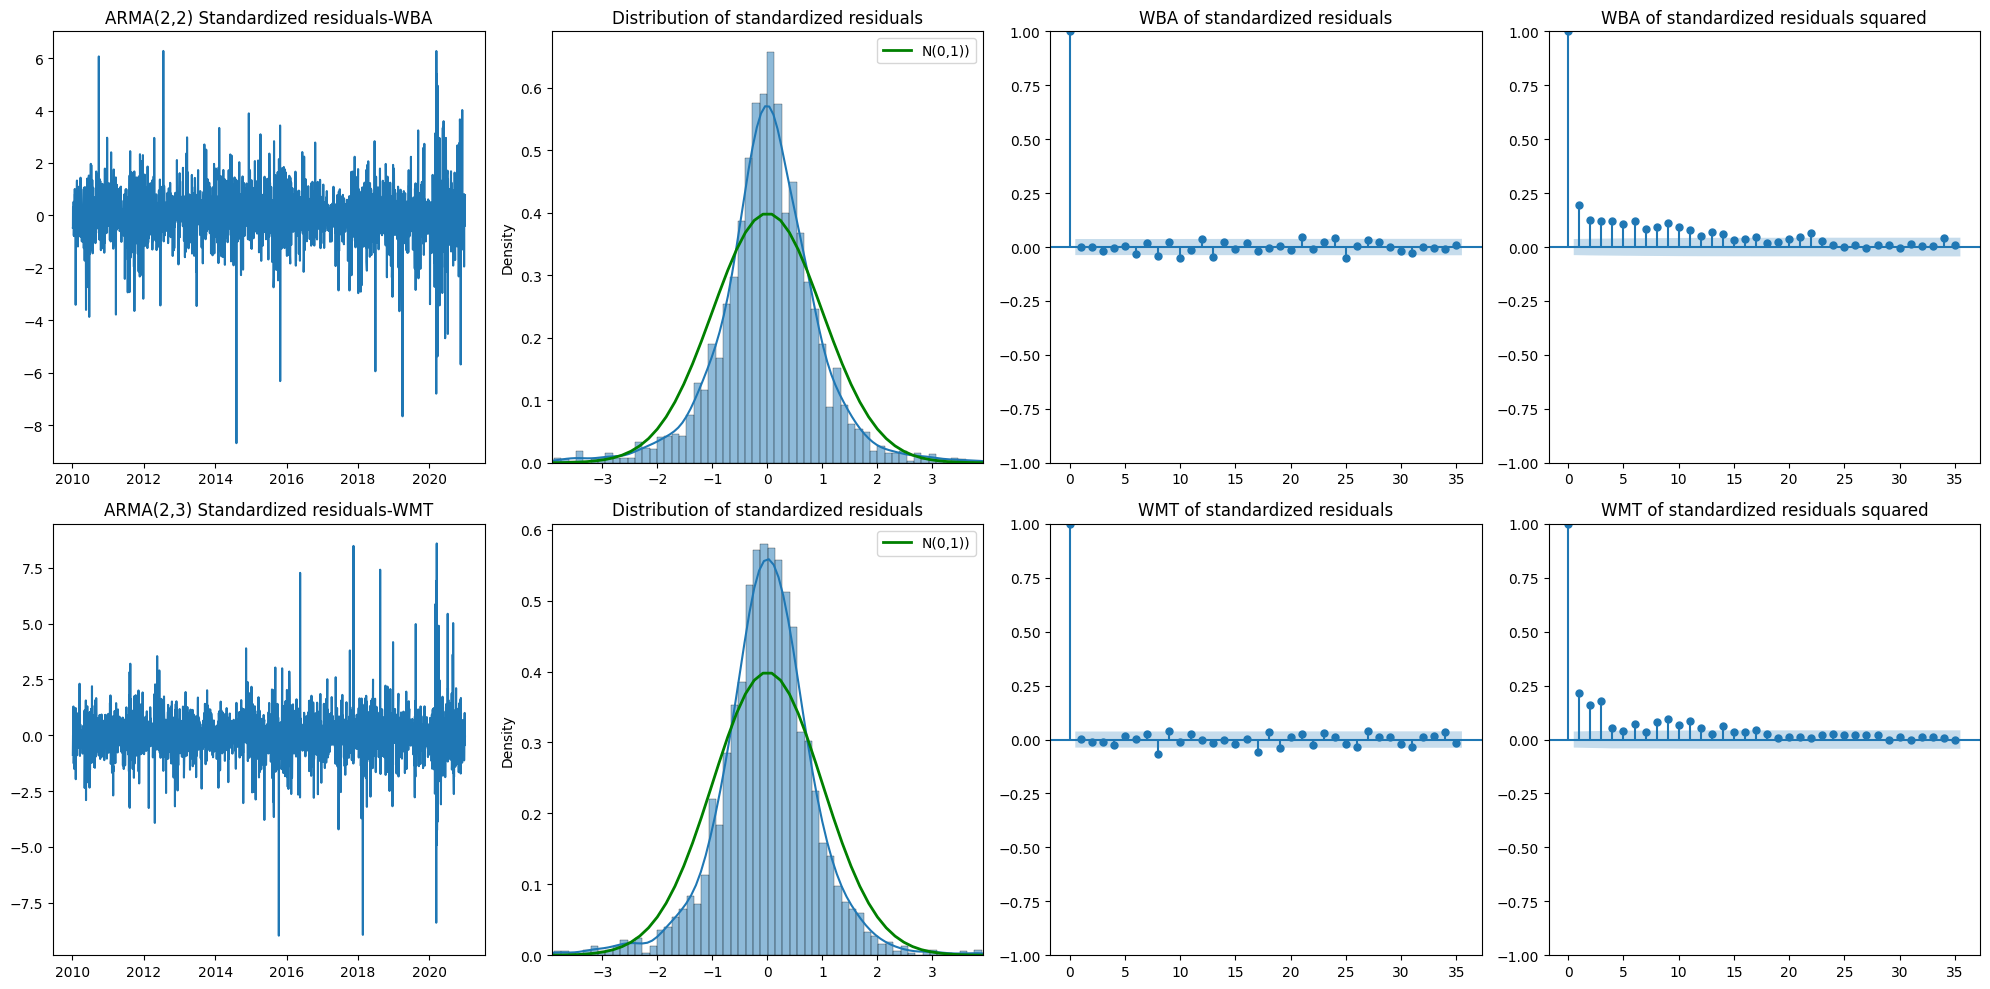

In [43]:
import statsmodels.api as sm
import seaborn as sns
import scipy.stats as scs

fig, axes = plt.subplots(nrows=2,ncols=4,figsize=(20,10))

for i,ticker in enumerate(my_sample):
    r = best_models[ticker].resid() # Extract residuals
    r = (r-r.mean())/r.std() # Standardized residuals
    p = best_models[ticker].order[0]
    q = best_models[ticker].order[2]


    # Time series plot of Standardized residuals
    axes[i, 0].plot(r, label='Standardized residuals')
    axes[i, 0].set_title(f'ARMA({p},{q}) Standardized residuals-{ticker}')


    # distribution of standardized residuals
    x_lim = (-1.96 * 2, 1.96 * 2)
    r_range = np.linspace(x_lim[0], x_lim[1])
    norm_pdf = scs.norm.pdf(r_range)
    sns.histplot(r,kde=True,stat='density',ax=axes[i,1])
    axes[i, 1].plot(r_range, norm_pdf, 'g', lw=2, label=f'N(0,1))')
    axes[i, 1].set_title('Distribution of standardized residuals')
    axes[i, 1].set_xlim(x_lim)
    axes[i, 1].legend()


    # ACF of standardized residuals
    plot_acf(r, ax = axes[i, 2], title = f'{ticker} of standardized residuals', alpha=0.05)


    # ACF plot
    plot_acf(r**2, ax = axes[i, 3], title = f'{ticker} of standardized residuals squared', alpha=0.05)

    plt.tight_layout()

### Task 2.3

In [44]:
garch_best_models = {}
for ticker in my_sample:
    aicVal=[]
    for p in range(0,4):
        for q in range(0,4):
            try:
                model = arch_model(y = 100*data_train[ticker]['return'],mean='AR',lags=best_models[ticker].order[0],vol='GARCH',p=p,o=0,q=q, dist='StudentsT')
                model = model.fit(update_freq=5, disp = False)
                aicVal.append([p, q, model.aic, model])
            except:
                continue
    aicVal = pd.DataFrame(aicVal, columns = ['p', 'q', 'aic', 'model'])
    garch_best_models[ticker] = aicVal.iloc[aicVal['aic'].argmin(),]
    print(f'Best-fittedAR(p)-GARCH(p*,q*)modelforWBA:AR({best_models[ticker].order[0]})-GARCH({garch_best_models[ticker]['p']},{garch_best_models[ticker]['q']})-AIC ={garch_best_models[ticker]['aic']:.4f}')


Best-fittedAR(p)-GARCH(p*,q*)modelforWBA:AR(2)-GARCH(1,1)-AIC =10137.8541
Best-fittedAR(p)-GARCH(p*,q*)modelforWBA:AR(2)-GARCH(3,0)-AIC =7743.4547


### Task 2.4

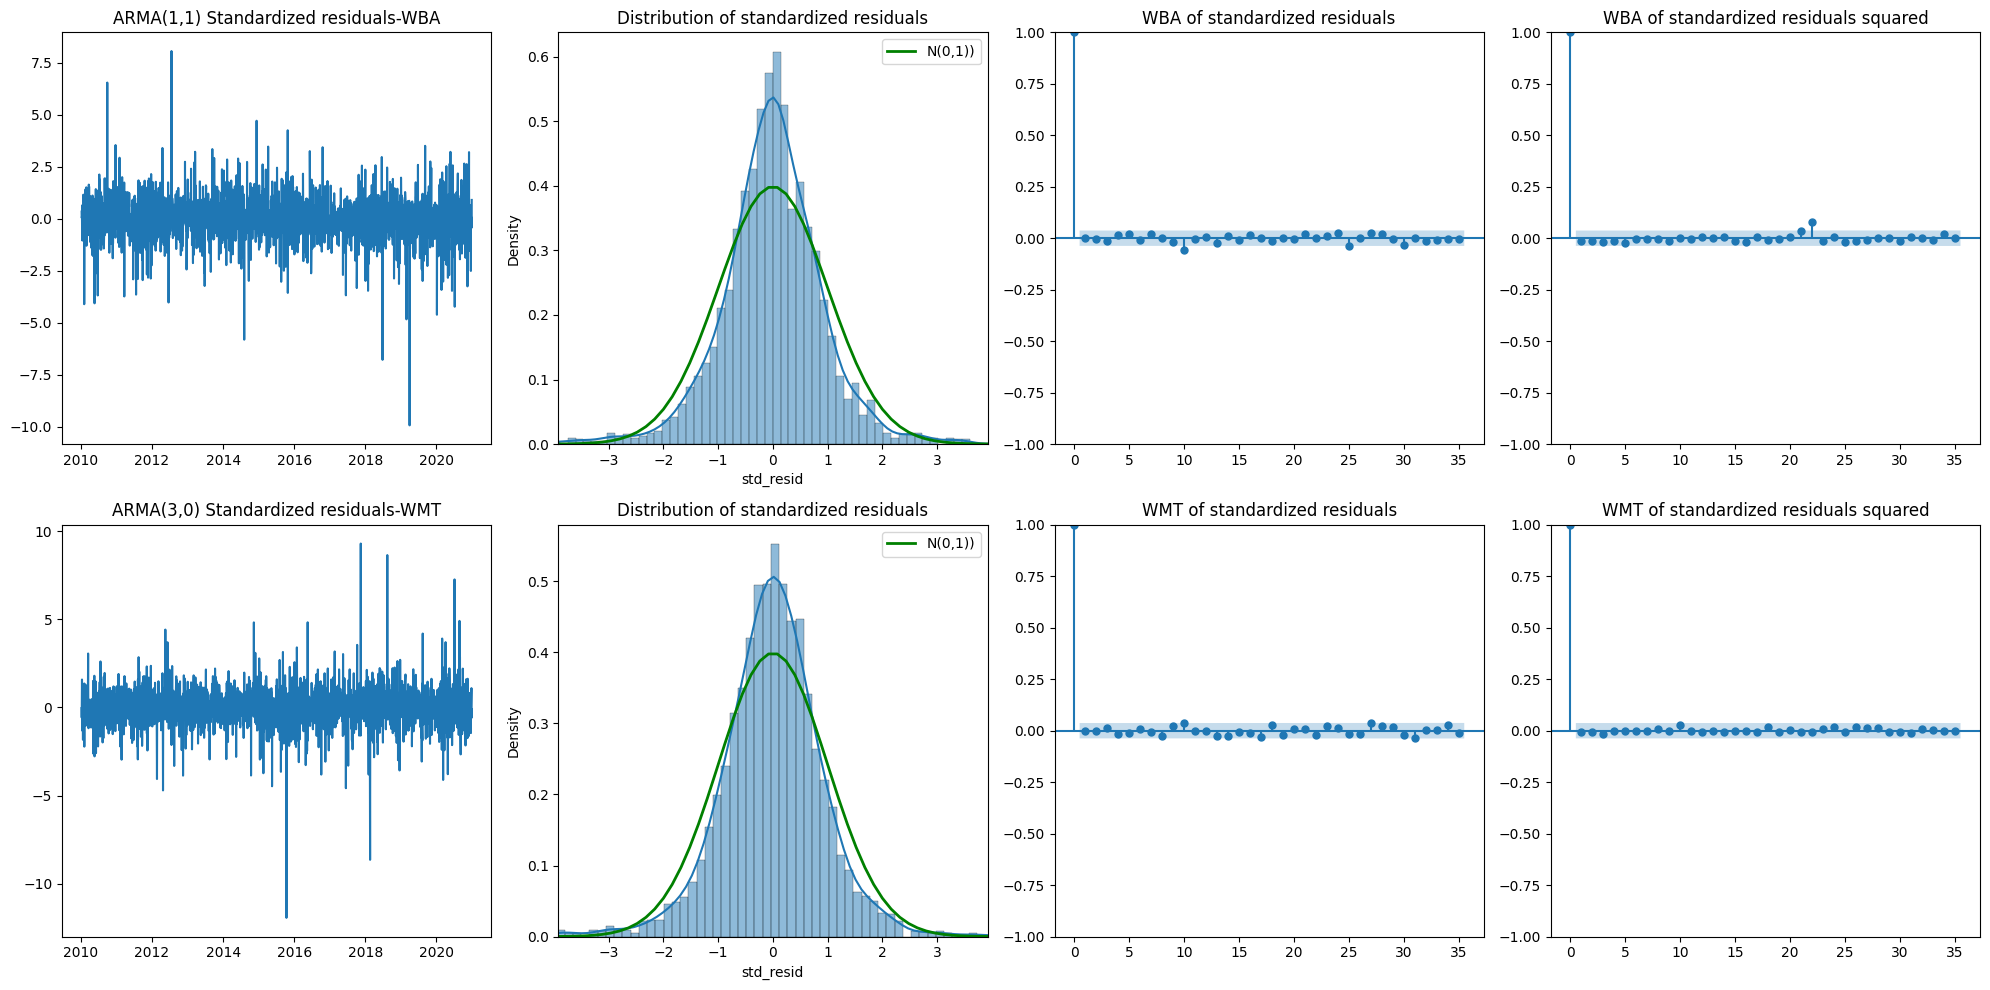

In [45]:
fig, axes = plt.subplots(nrows=2,ncols=4,figsize=(20,10))

for i,ticker in enumerate(my_sample):
    r = garch_best_models[ticker]['model'].std_resid.dropna()
    p = garch_best_models[ticker]['p']
    q = garch_best_models[ticker]['q']


    # Time series plot of Standardized residuals
    axes[i, 0].plot(r, label='Standardized residuals')
    axes[i, 0].set_title(f'ARMA({p},{q}) Standardized residuals-{ticker}')


    # distribution of standardized residuals
    x_lim = (-1.96 * 2, 1.96 * 2)
    r_range = np.linspace(x_lim[0], x_lim[1])
    norm_pdf = scs.norm.pdf(r_range)
    sns.histplot(r,kde=True,stat='density',ax=axes[i,1])
    axes[i, 1].plot(r_range, norm_pdf, 'g', lw=2, label=f'N(0,1))')
    axes[i, 1].set_title('Distribution of standardized residuals')
    axes[i, 1].set_xlim(x_lim)
    axes[i, 1].legend()


    # ACF of standardized residuals
    plot_acf(r, ax = axes[i, 2], title = f'{ticker} of standardized residuals', alpha=0.05)


    # ACF plot
    plot_acf(r**2, ax = axes[i, 3], title = f'{ticker} of standardized residuals squared', alpha=0.05)

    plt.tight_layout()

### Task 2.5

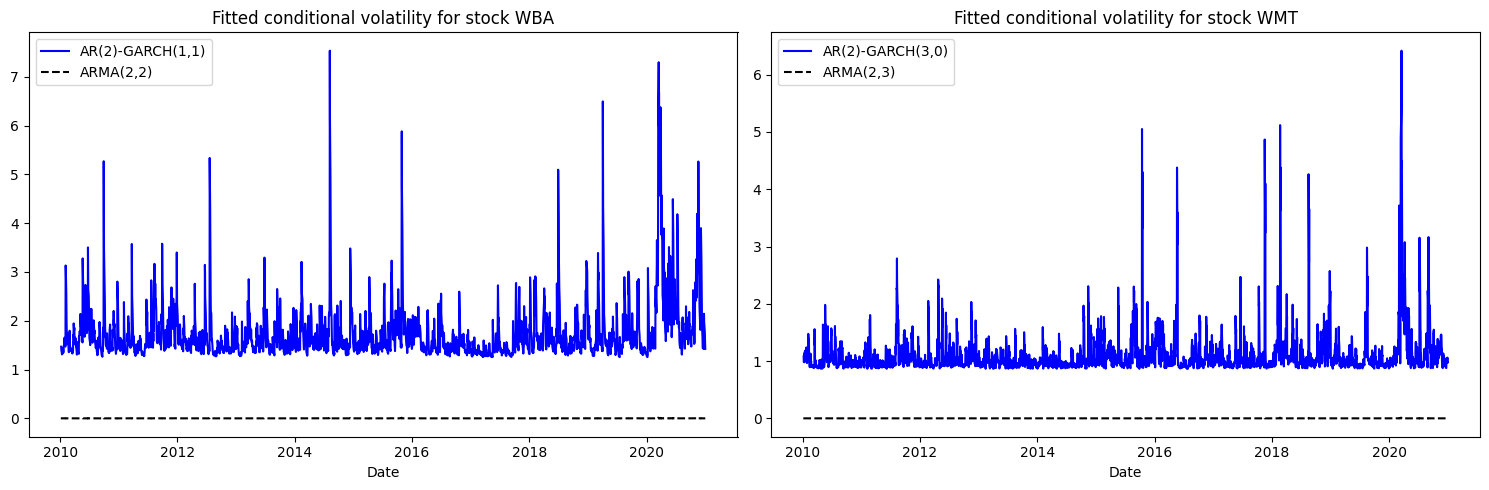

In [46]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
for i,ticker in enumerate(my_sample):
    conditional_volatility = garch_best_models[ticker]['model'].conditional_volatility
    axes[i].plot(conditional_volatility, color = 'blue', linestyle = '-', label=f'AR({best_models[ticker].order[0]})-GARCH({garch_best_models[ticker]['p']},{garch_best_models[ticker]['q']})')
    axes[i].plot(((best_models[ticker].resid()/100)**2), color = 'black', linestyle = '--', label = f'ARMA({best_models[ticker].order[0]},{best_models[ticker].order[2]})')
    axes[i].set_title(f'Fitted conditional volatility for stock {ticker}')
    axes[i].set_xlabel('Date')  
    axes[i].legend(loc='upper left')
plt.tight_layout()
plt.show()

# Task 3

### Task 3.1

In [47]:
data_oos = data.loc['2021-01-01':].copy()

fcast_for_each_stock_arma = {}

# Initialize one-step fcast for price
for ticker in my_sample:
    arima_p = SARIMAX(data_train[ticker]['return'],order=best_models[ticker].order,trend='c').fit(maxiter=200) 

    fcast_df = pd.DataFrame(index=data_oos.index)
    fcast_df[['f','fl','fu']] = np.nan

    for fdate in data_oos.index:
        # Step 1: Get an expanded in-sample data by one obs at a time
        y = data[ticker].loc[data[ticker].index < fdate, 'return']
        
        # Step 2: Apply the estimated model to the new data
        arima_p_ext = arima_p.apply(y, refit=False)
        
        # Step 3: Produce one-step ahead forecast
        fcast = arima_p_ext.get_forecast().summary_frame()[['mean','mean_ci_lower',  'mean_ci_upper']]

        # Save forecasts
        fcast_df.loc[fdate, ['f','fl','fu']] = np.array(fcast.iloc[0])
        
    fcast_for_each_stock_arma[ticker] = fcast_df

for ticker in my_sample:
    print(ticker)
    print(fcast_for_each_stock_arma[ticker].head())

WBA
                   f        fl        fu
Date                                    
2021-01-04  0.000030 -0.034738  0.034799
2021-01-05 -0.001254 -0.036022  0.033515
2021-01-06 -0.001647 -0.036416  0.033121
2021-01-07 -0.002015 -0.036784  0.032753
2021-01-08 -0.003449 -0.038217  0.031319
WMT
                   f        fl        fu
Date                                    
2021-01-04  0.000566 -0.022702  0.023834
2021-01-05 -0.001034 -0.024302  0.022234
2021-01-06  0.000886 -0.022382  0.024154
2021-01-07 -0.000212 -0.023480  0.023056
2021-01-08  0.000487 -0.022781  0.023755


### Task 3.2

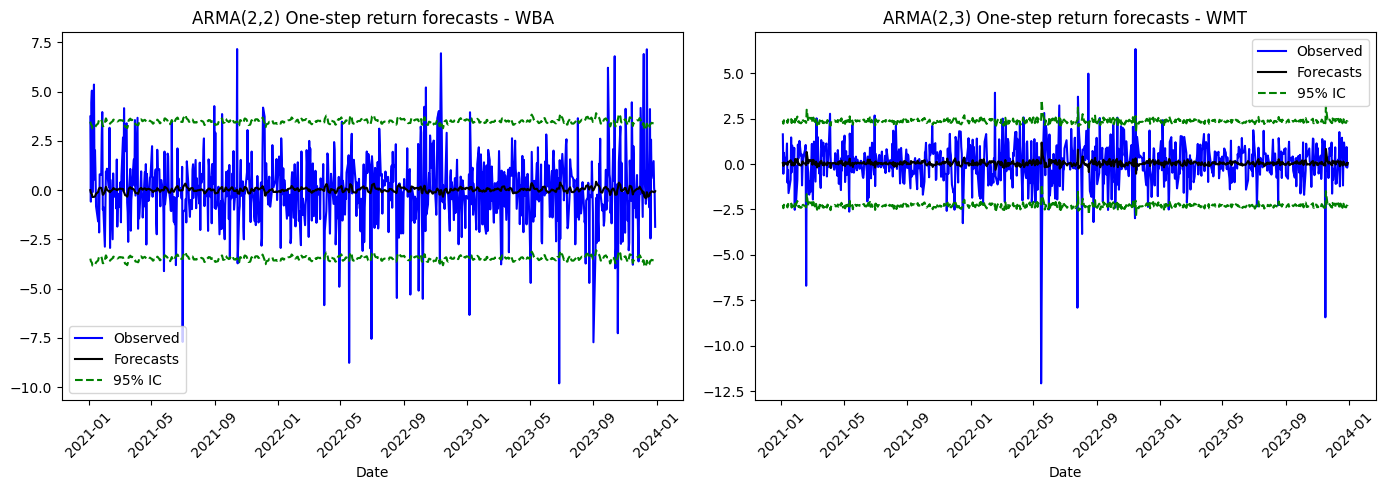

In [48]:
fig, axes = plt.subplots(1, 2, figsize = (14,5))
for i,ticker in enumerate(my_sample):
    axes[i].plot(data_oos[ticker]['return']*100, c = 'blue', label = 'Observed')
    axes[i].plot(fcast_for_each_stock_arma[ticker]['f']*100, c = 'black', label = 'Forecasts')
    axes[i].plot(fcast_for_each_stock_arma[ticker]['fl']*100, c = 'green', linestyle = '--', label = '95% IC')
    axes[i].plot(fcast_for_each_stock_arma[ticker]['fu']*100, c = 'green', linestyle = '--')
    axes[i].set_title(f'ARMA({best_models[ticker].order[0]},{best_models[ticker].order[2]}) One-step return forecasts - {ticker}')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_xlabel('Date')
    axes[i].legend()


plt.tight_layout()
plt.show()

### Task 3.3

In [49]:
split_date = '2021-01-01'
fcast_for_each_stock_garch = {}

for i,ticker in enumerate(my_sample):
    garch = arch_model(y=data[ticker]['return']*100, mean='AR',lags=best_models[ticker].order[0],vol='GARCH',p=int(garch_best_models[ticker]['p']),o=0, q=garch_best_models[ticker]['q'])
    garch_fcast = garch.fit(last_obs = split_date, disp = 'off').forecast(reindex=False)

    r_true = 100*data[ticker].loc[data.index>=split_date,'return']
    f = garch_fcast.mean['h.1']
    var_fcast = garch_fcast.variance['h.1']
    fl = f - 1.96*var_fcast**0.5 # Lower bound 95%
    fu = f + 1.96*var_fcast**0.5 # Upper bound 95%

    fcast_df = pd.DataFrame({'f': f, 'fl': fl, 'fu': fu})
    fcast_for_each_stock_garch[ticker] = fcast_df.iloc[1:,:]

for ticker in my_sample:
    print(ticker)
    print(fcast_for_each_stock_garch[ticker].head())

WBA
                   f        fl        fu
Date                                    
2021-01-04 -0.094656 -4.255380  4.066067
2021-01-05 -0.129581 -3.783096  3.523934
2021-01-06 -0.024581 -5.036944  4.987782
2021-01-07 -0.241151 -6.224558  5.742255
2021-01-08 -0.190700 -5.160178  4.778778
WMT
                   f        fl        fu
Date                                    
2021-01-04 -0.014320 -2.432873  2.404233
2021-01-05 -0.000851 -2.044778  2.043075
2021-01-06  0.071261 -2.017190  2.159711
2021-01-07  0.033587 -1.768857  1.836032
2021-01-08  0.072675 -1.702518  1.847868


### Task 3.4

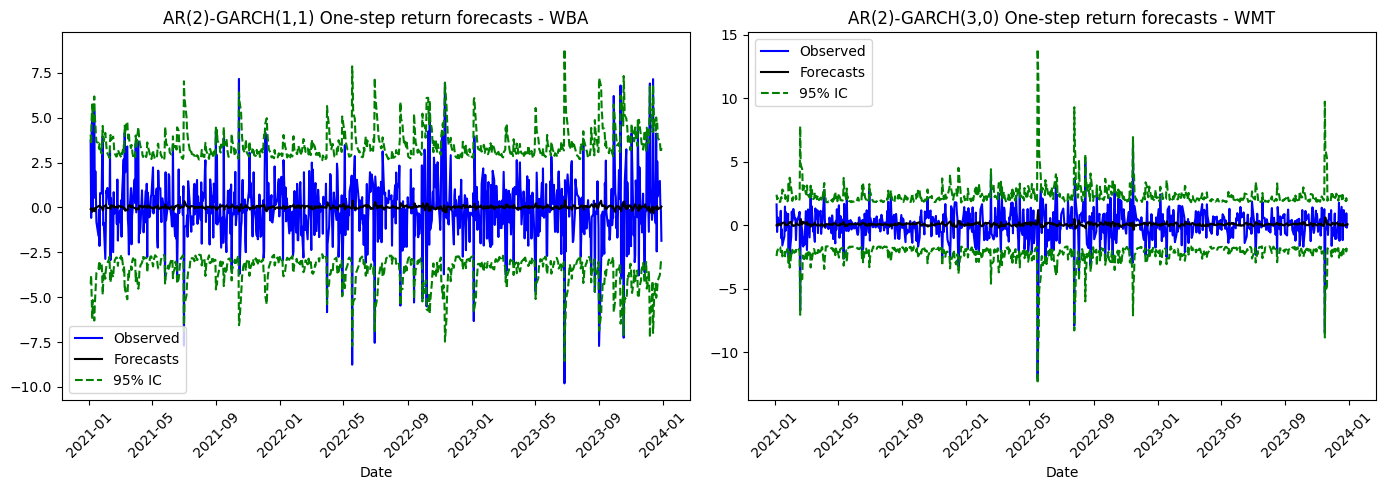

In [50]:
fig, axes = plt.subplots(1, 2, figsize = (14,5))
for i,ticker in enumerate(my_sample):
    axes[i].plot(data_oos[ticker]['return']*100, c = 'blue', label = 'Observed')
    axes[i].plot(fcast_for_each_stock_garch[ticker]['f'], c = 'black', label = 'Forecasts')
    axes[i].plot(fcast_for_each_stock_garch[ticker]['fl'], c = 'green', linestyle = '--', label = '95% IC')
    axes[i].plot(fcast_for_each_stock_garch[ticker]['fu'], c = 'green', linestyle = '--')
    axes[i].set_title(f'AR({best_models[ticker].order[0]})-GARCH({garch_best_models[ticker]['p']},{garch_best_models[ticker]['q']}) One-step return forecasts - {ticker}')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_xlabel('Date')
    axes[i].legend()

plt.tight_layout()
plt.show()

### Task 3.5

In [51]:
# Function to compute forecast accuracy measures
def forecast_accuracy(fcast, true, return_df=True):
    '''
    Input:
        fcast: a 1-D array-like object of forecasts
        true: a 1-D array-like object of true values, same length as fcast
        return_df: return output as a dataframe
    Output:
        MAE: Mean Absolute Error 
        RMSE: Root Mean Squared Error
    '''
    fcast = np.array(fcast)
    true = np.array(true)
    
    if len(fcast) != len(true):
        raise ValueError('`fcast` and `true` must have same length.')
    
    ferror = true - fcast
    MAE = np.mean(np.absolute(ferror))
    MSE = np.mean(ferror**2)
    MAPE = np.mean(np.absolute(ferror/true))
    MASE =  MAE / np.mean(np.abs(np.diff(true)))

    
    out = {'MAE': MAE, 'MSE': MSE, 'MAPE': MAPE, 'MASE': MASE}
    if return_df:
        out = pd.DataFrame(out, index = [0])
    
    return out
    

In [52]:
forecast_accuracy(fcast_for_each_stock_arma[ticker]['f']*100, data_oos[ticker]['return']*100)

,MAE,MSE,MAPE,MASE
0,0.874715,1.704384,1.17391,0.714421


In [33]:
for ticker in my_sample:
    print(forecast_accuracy(fcast_for_each_stock_arma[ticker]['f']*100, data_oos[ticker]['return']*100))
    print(forecast_accuracy(fcast_for_each_stock_garch[ticker]['f'], data_oos[ticker]['return']*100))

        MAE     MSE  MAPE      MASE
0  1.379268  3.7339   inf  0.691437
        MAE       MSE  MAPE      MASE
0  1.399649  3.836737   inf  0.701654
        MAE       MSE     MAPE      MASE
0  0.874715  1.704384  1.17391  0.714421
       MAE       MSE      MAPE      MASE
0  0.91674  1.874565  1.210051  0.748745


In [ ]:
fcast_for_each_stock_arma[ticker]['f']

Date
2021-01-04    0.000566
2021-01-05   -0.001034
2021-01-06    0.000886
2021-01-07   -0.000212
2021-01-08    0.000487
                ...   
2023-12-22   -0.000144
2023-12-26   -0.000569
2023-12-27    0.000502
2023-12-28   -0.000500
2023-12-29    0.000613
Name: f, Length: 753, dtype: float64

In [ ]:
fcast_for_each_stock_garch[ticker]['f']

Date
2021-01-04   -0.014319
2021-01-05   -0.000848
2021-01-06    0.071260
2021-01-07    0.033587
2021-01-08    0.072675
                ...   
2023-12-22   -0.035165
2023-12-26    0.006577
2023-12-27    0.031194
2023-12-28    0.024419
2023-12-29    0.080924
Name: f, Length: 753, dtype: float64

In [ ]:
data_oos[ticker]['return']

Date
2021-01-04    0.016376
2021-01-05   -0.005338
2021-01-06    0.006224
2021-01-07   -0.000068
2021-01-08   -0.000137
                ...   
2023-12-22    0.011880
2023-12-26   -0.001533
2023-12-27    0.009355
2023-12-28   -0.001965
2023-12-29    0.000508
Name: return, Length: 753, dtype: float64